In [1]:
#importing libraries
import pandas as pd
from ydata_profiling import ProfileReport
from datetime import timedelta
import tkinter
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('TkAgg')
%matplotlib inline

In [2]:
#Quick EDA on the raw data using profile report
json = pd.read_json('ultimate_data_challenge.json')
df = pd.DataFrame(json)
profile = ProfileReport(df, title="Data")
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

#### To summarize the findings above:
##### The data set contains 50,000 records and quite comprehensive.  
##### The variables with missing data include:
    ##### avg_rating_of_driver, 16.2% missing
    ##### phone, .8% missing
    ##### avg_rating_by_driver, .4% missing
##### The data set has 8 duplicated rows.

#### The plan moving forward is to impute the average ratings missing values and investigate potential imputing solution for phone if necessary.

#### The numerical data will need to be scaled.  Ratings variables range from 0 to 5, while average distance ranges from 0 to 160.96.

In [3]:
#Removing duplicated rows.
df = df.drop_duplicates()

In [4]:
# Next I want to check the data type of the signup and trip date series.
print(type(df.last_trip_date[0]))
print(type(df.signup_date[0]))

<class 'str'>
<class 'str'>


In [5]:
df.last_trip_date = pd.to_datetime(df.last_trip_date)
df.signup_date = pd.to_datetime(df.signup_date)
#df.last_trip_date.apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))

/var/folders/j4/96_5xmgd7j362v_w7_09bvb40000gn/T/ipykernel_16313/4144113633.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.last_trip_date = pd.to_datetime(df.last_trip_date)
/var/folders/j4/96_5xmgd7j362v_w7_09bvb40000gn/T/ipykernel_16313/4144113633.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.signup_date = pd.to_datetime(df.signup_date)


In [6]:
print(type(df.last_trip_date[0]))
print(type(df.signup_date[0]))

<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>


### Target Variable 

#### We know from the instructions that we want to begin with the users who signed up in January 2014.

In [7]:
# Creating new dataframe with only january 2014 signups
jan_2014_signups = df[df['signup_date'].dt.year == 2014]
jan_2014_signups = jan_2014_signups[jan_2014_signups['signup_date'].dt.month == 1]
jan_2014_signups_total = len(jan_2014_signups)

In [8]:
df[df.signup_date.dt.month != 1]

Empty DataFrame
Columns: [city, trips_in_first_30_days, signup_date, avg_rating_of_driver, avg_surge, last_trip_date, phone, surge_pct, ultimate_black_user, weekday_pct, avg_dist, avg_rating_by_driver]
Index: []

#### All of the signups in the data happened in January 2014.

In [9]:
print("The most recent trip timestamp: ", df.last_trip_date.max())
print('30 day "active user" cutoff: {}'.format(df.last_trip_date.max() - timedelta(30)))

The most recent trip timestamp:  2014-07-01 00:00:00
30 day "active user" cutoff: 2014-06-01 00:00:00


#### The above results show the bounds of timestamps for sorting active users in the data.

In [10]:
jan_2014_signups_active = jan_2014_signups[(jan_2014_signups['last_trip_date'] >= '2014-06-01') & (jan_2014_signups['last_trip_date'] <= '2014-07-01')]
jan_2014_signups_total_active = jan_2014_signups_active.shape[0]
print(jan_2014_signups_total_active)

18804


### Fraction of retained users:

In [11]:
print("The fraction of retained users who signed up in January 2014 is ", '{:.2%}'.format(jan_2014_signups_total_active/jan_2014_signups_total))

The fraction of retained users who signed up in January 2014 is  37.61%


### Dealing with records missing ratings values

In [12]:
#Labeling records in the original dataset as 1 for retained, and 0 for not retained.
df['retained'] = 0
df.loc[(df['last_trip_date'] >= '2014-06-01') & (df['last_trip_date'] <= '2014-07-01'), 'retained'] = 1

/var/folders/j4/96_5xmgd7j362v_w7_09bvb40000gn/T/ipykernel_16313/2130273466.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['retained'] = 0


In [13]:
df = df.drop('last_trip_date', axis = 1)

### Exploring the data for records missing ratings

In [14]:
avg_rating_of_driver = df.avg_rating_of_driver.mean()
avg_rating_by_driver = df.avg_rating_by_driver.mean()
print("The average rating of an Ulitmate driver partner by a rider: ",avg_rating_of_driver)
print("The average rating of a rider by an Ultimate driver partner: ",avg_rating_by_driver)

The average rating of an Ulitmate driver partner by a rider:  4.60151171399231
The average rating of a rider by an Ultimate driver partner:  4.778122552268482


#### Since the range of ratings is bounded to the interval [0,5] the means of each series will be used to impute missing data.

In [15]:
df.avg_rating_of_driver = df.avg_rating_of_driver.fillna(avg_rating_of_driver)
df.avg_rating_by_driver = df.avg_rating_by_driver.fillna(avg_rating_by_driver)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49992 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    49992 non-null  object        
 1   trips_in_first_30_days  49992 non-null  int64         
 2   signup_date             49992 non-null  datetime64[ns]
 3   avg_rating_of_driver    49992 non-null  float64       
 4   avg_surge               49992 non-null  float64       
 5   phone                   49596 non-null  object        
 6   surge_pct               49992 non-null  float64       
 7   ultimate_black_user     49992 non-null  bool          
 8   weekday_pct             49992 non-null  float64       
 9   avg_dist                49992 non-null  float64       
 10  avg_rating_by_driver    49992 non-null  float64       
 11  retained                49992 non-null  int64         
dtypes: bool(1), datetime64[ns](1), float64(6), int

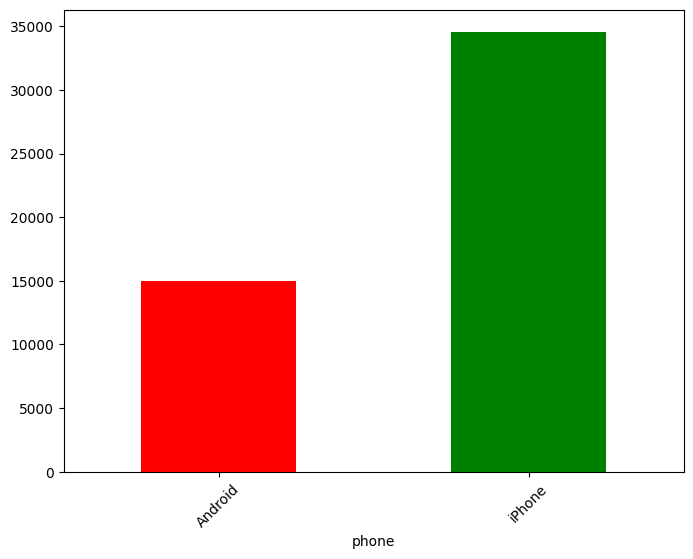

In [17]:
phone_eda = df.groupby(['phone'])['avg_dist'].count()
phone_eda.plot(kind = 'bar', figsize = (8,6), color = ['r','g'], rot = 45)
plt.show()

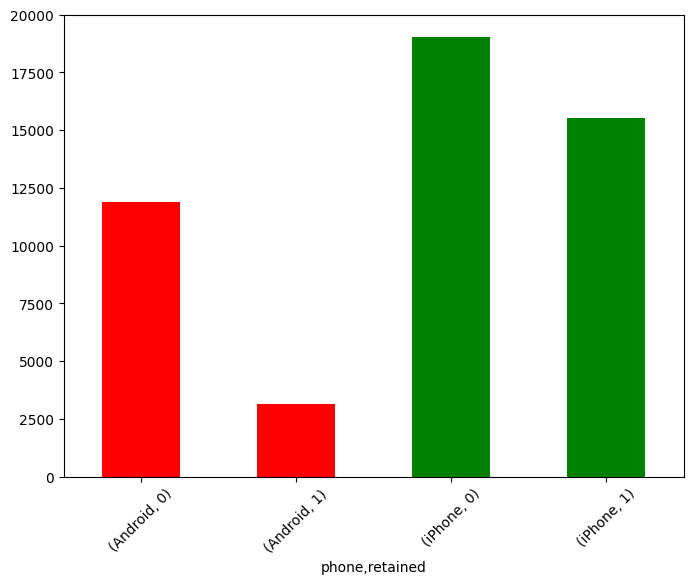

phone    retained
Android  0           11872
         1            3146
iPhone   0           19053
         1           15525
Name: avg_dist, dtype: int64

In [18]:
phone_vis = df.groupby(['phone','retained'])['avg_dist'].count()
phone_vis.plot(kind = 'bar', figsize = (8,6), color = ['r','r','g','g'], rot = 45)
plt.show()
phone_vis

In [19]:
print('Android loss percent: {}', '{:.2%}'.format(phone_vis[0]/ (phone_vis[0]+phone_vis[1])))
print('iPhone loss percent: {}', '{:.2%}'.format(phone_vis[2]/ (phone_vis[0]+phone_vis[3])))

Android loss percent: {} 79.05%
iPhone loss percent: {} 69.54%


#### There is a bigger drop of retained riders using Android, but there are many more iPhone users overall.  I will drop this column from the data, along with signup_date since all records begin in January 2014.

In [20]:
# Dropping the phone and signup_date series
df = df.drop(['phone','signup_date'], axis = 1)

#### I want to transform the 'ultimate_black_user' column into a series of numeric codes, where each code represents a unique category in the original column.

In [21]:
df.ultimate_black_user = df.ultimate_black_user.astype('category').cat.codes

#### The last variable to investigate is city.

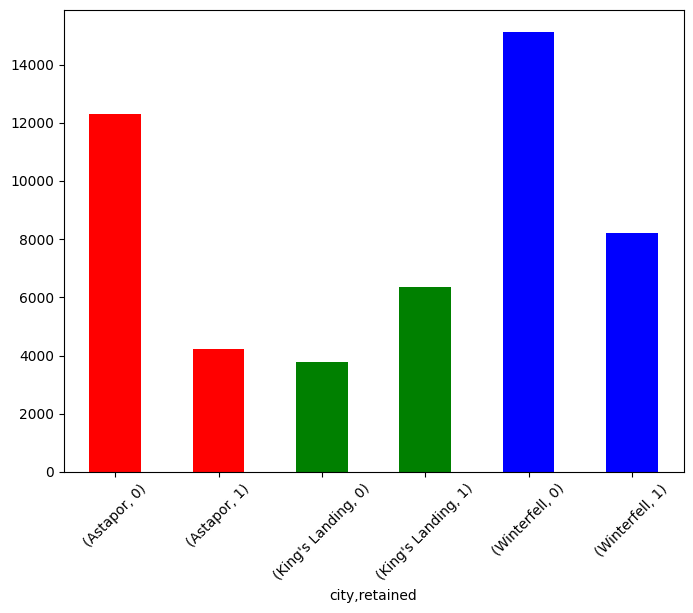

city            retained
Astapor         0           12303
                1            4228
King's Landing  0            3767
                1            6363
Winterfell      0           15118
                1            8213
Name: avg_dist, dtype: int64

In [22]:
city_ret = df.groupby(['city','retained'])['avg_dist'].count()
city_ret.plot(kind = 'bar', figsize = (8,6), color = ['r','r','g','g','b','b',], rot = 45)
plt.show()
city_ret

#### There are three cities in the data, Astapor, King's Landing, and Winterfell.

In [23]:
print('Astapor loss percent: ', '{:.2%}'.format(city_ret[0]/(city_ret[0]+city_ret[1])))
print('King\'s Landing loss percent: ', '{:.2%}'.format(city_ret[2]/(city_ret[2]+city_ret[3])))
print('Winterfell loss percent: ', '{:.2%}'.format(city_ret[4]/(city_ret[4]+city_ret[5])))

Astapor loss percent:  74.42%
King's Landing loss percent:  37.19%
Winterfell loss percent:  64.80%


#### King's Landing has the best rider retention out of all three, then Winterfell and lastly Astapor.

In [24]:
print('Astapor rider records: ', city_ret[0]+city_ret[1])
print('King\'s Landing rider records: ', city_ret[2]+city_ret[3])
print('Winterfell rider records: ', city_ret[4]+city_ret[5])

Astapor rider records:  16531
King's Landing rider records:  10130
Winterfell rider records:  23331


#### Rider record totals based on City are listed in descending order are the following: Winterfell, Astapor, King's Landing.
#### There seems to be an issue with King's Landing, they had a very high loss percent and overall represent the smallest subset of the data.

#### I want to transform the 'city' column into a series of numeric codes, where each code represents a unique category in the original column.

In [25]:
df.city = df.city.astype('category').cat.codes

In [26]:
df.head()

city  trips_in_first_30_days  avg_rating_of_driver  avg_surge  surge_pct  \
0     1                       4                   4.7       1.10       15.4   
1     0                       0                   5.0       1.00        0.0   
2     0                       3                   4.3       1.00        0.0   
3     1                       9                   4.6       1.14       20.0   
4     2                      14                   4.4       1.19       11.8   

   ultimate_black_user  weekday_pct  avg_dist  avg_rating_by_driver  retained  
0                    1         46.2      3.67                   5.0         1  
1                    0         50.0      8.26                   5.0         0  
2                    0        100.0      0.77                   5.0         0  
3                    1         80.0      2.36                   4.9         1  
4                    0         82.4      3.13                   4.9         0

## Preparing the data for modeling

In [27]:
x_data = df.drop('retained', axis = 1)
y_data = df.retained

## Train test split for predictive models

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.3, random_state=42)

## This is supervised learning classification type problem

##### I'm planning to try gradient booster, and random forest.

## Gradient Boosting Classifier

In [29]:
from sklearn.ensemble import GradientBoostingClassifier

In [33]:
gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)
y_pred = gb_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.7764368582477663


## Random Forest Classifier

In [34]:
from sklearn.ensemble import RandomForestClassifier

In [35]:
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.744432591012135


##### The Gradient Boosting Classifier model had a slight edge on accuracy over the Random Forest Classifier.  